In [67]:
#Load necessary packages
import pandas as pd
import os
import numpy as np
import copy

import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from numpy.polynomial.polynomial import polyfit

### Data Prep - all code condensed from Library_Week2_Notebook4_Strategy#2

In [3]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Load data
os.chdir("//Users/Olga/Documents/INSIGHT2019/Library data/AllPldData")
Files_in_folder = os.listdir()
File_names = ['_2014', '_2015', '_2016', '_2001', '_2002', '_2003', 
              '_2004','_2005', '_2006', '_2007', '_2008', '_2009', 
              '_2010', '_2011', '_2012', '_2013', '_2000', '_1992', 
              '_1993', '_1994', '_1995', '_1996', '_1997', '_1998', '_1999']
Files = []

for filename in os.listdir():
    if filename.endswith('csv'):
        Files.append(pd.read_csv(filename, encoding = 'latin-1', low_memory = False))
        
#create dictionary of libraries labeled by year
LibData_dict = {}
for i in range(0, len(File_names)):
    LibData_dict[File_names[i]] = Files[i]
    
for k, v in LibData_dict.items():
    print(k, v.shape, type(LibData_dict[k]))

ColumnsPresent = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict.items():
    dataframe_to_join = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent = ColumnsPresent.join(dataframe_to_join, how = 'outer')

#Rearrange columns in dataframe. 
cols = ColumnsPresent.columns.tolist()
cols_rearr = cols[17:] + cols[0:17]
cols_rearr2 = cols_rearr[0:8] + cols_rearr[24:25] + cols_rearr[11:24] + cols_rearr[8:11]

ColumnsPresent_rearr = ColumnsPresent[cols_rearr2]

ColumnsPresent_rearr_str = ColumnsPresent_rearr.applymap(str)
ColumnsPresent_rearr_str = ColumnsPresent_rearr_str.reset_index(drop = True)

#create DF of unique column values
UniqueLabels = np.unique(ColumnsPresent_rearr_str.values)
LabelsBoolDF = pd.DataFrame(UniqueLabels)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_rearr_str.columns)):
    lis = []
    for i in range(len(UniqueLabels)):
        lis.append(ColumnsPresent_rearr_str.iloc[:, j].isin([UniqueLabels[i]]).any())
    LabelsBoolDF[ColumnsPresent_rearr_str.columns[j]] = lis
    
## Sum all TRUE values. Value of 25 = all true
sum_list = []
for i in range(LabelsBoolDF.shape[0]):
    sum_list.append(sum(LabelsBoolDF.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF['TRUE SUM'] = sum_list
LabelsBoolDF['Notes'] = ""
LabelsBoolDF.loc[LabelsBoolDF[LabelsBoolDF['TRUE SUM']==25].index, 'Notes'] = "OK"

#rows in which not all TRUE (meaning this column/data does not exist for all year)
MissingData = LabelsBoolDF[LabelsBoolDF['TRUE SUM']!=25].index.tolist()

#Column names to keep
#LabelsBoolDF.loc[[0, 3:13, 15], 0].tolist()
Cols_to_keep_idx = [0]
Cols_to_keep_idx.extend(range(3,13))
Cols_to_keep_idx.extend((16, 18, 20, 25, 26))
Cols_to_keep_idx.extend(range(33, 49))
Cols_to_keep_idx.extend((64, 135, 137, 138, 183))
Cols_to_keep_idx.extend(range(185, 189))
Cols_to_keep_idx.extend(range(191, 199))
Cols_to_keep_idx.append(201)
Cols_to_keep_idx.extend(range(206, 219))
Cols_to_keep_idx.append(220)
Cols_to_keep_idx.extend(range(222, 229))
Cols_to_keep_idx.extend((230, 231, 237))
Cols_to_keep_idx.extend(range(237, 256))
Cols_to_keep_idx.extend(range(257, 260))
Cols_to_keep_idx.extend((262, 263))

Cols_to_keep_in_lib_dfs = LabelsBoolDF.iloc[Cols_to_keep_idx, 0].tolist()

#Make dictionaries of smaller dataframe with Cols_to_keep_in_lib_dfs ONLY
LibData_dict_reduced = dict()

for k, v in LibData_dict.items():
    LibData_dict_reduced[k] = pd.DataFrame()
    for i in Cols_to_keep_in_lib_dfs:
        if i in v:
            TempList = list(v[i])
            LibData_dict_reduced[k][i] = TempList

#Did above loop do what I thought it did?
print("Original dfs:")
for k, v in LibData_dict.items():
    print(k, v.shape)

print("\n", "Reduced dfs:")  
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Combine col names that mean same thing in different years into single 
Names_to_combine = ["ATTEND", "VISITS",  "C_LEGBAS", "C_LEGBASE", "DUPLI", "HRS_OPEN", "KIDATTEN", "KIDATTEND", 
                    "LIBRARIAN", "LIBRARIA", "POPU", "POPU_LSA", "POPU_UND", "POPU_UNDUP", "REFERENC", "REFERENCE", 
                    "STAFFEXP", "TOTEXP", "SUBSCRIP", "SUBSCRIPT", "TOTEXPCO", "TOTEXPCOL", 
                    "TOTOPEXP", "TOTOPEXP1", "TOTPEMP", "TOTSTAFF", "ZIP", "ZIP1"]

for i in range(0, len(Names_to_combine)-1, 2):
    for k, v in LibData_dict_reduced.items(): 
        if Names_to_combine[i] in v:
            name = Names_to_combine[i]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name: newname}, inplace = True)
        elif Names_to_combine[i+1] in v:
            name = Names_to_combine[i + 1]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name : newname}, inplace = True)

#Check that above code worked - names changes
for k, v in LibData_dict_reduced.items():
    print(v.columns)

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Columns to add to DFs
"AUDIO is divided into AUDIO_PH, AUDIO_DL starting 2010. Source: 2010 Documentation."
"VIDEO was later split into VIDEO_DL and VIDEO_PH."

for k, v in LibData_dict_reduced.items(): 
    if "AUDIO_DL" in v:
        v["AUDIO"] = v['AUDIO_DL'] + v['AUDIO_PH']
    if "VIDEO_DL" in v:
        v["VIDEO"] = v['VIDEO_DL'] + v['VIDEO_PH']

#Check that # columns in some dataframes increased by 2 (expected)
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Create DF w boolean values for prensence of each unique value in REDUCED dataframes
#THIS IS THE END GOAL OF THIS DATA

#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict_reduced.items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')

ColumnsPresent_reduced_str = ColumnsPresent_reduced.applymap(str)
ColumnsPresent_reduced_str = ColumnsPresent_reduced_str.reset_index(drop = True)
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF_reduced['TRUE SUM'] = sum_list_reduced
LabelsBoolDF_reduced['Notes'] = ""
LabelsBoolDF_reduced.loc[LabelsBoolDF_reduced[LabelsBoolDF_reduced['TRUE SUM']==25].index, 'Notes'] = "OK"

All_Cols_in_Reduced_dfs = list(LabelsBoolDF_reduced[0])
All_Cols_in_Reduced_dfs

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Delete columns deemed NOT useful for downstream analysis
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'TOTCOLL', 'ZIP-ZIP1']

LibData_dict_reduced_dropuseless = copy.deepcopy(LibData_dict_reduced)

for k, v in LibData_dict_reduced_dropuseless.items(): 
    for i in range(len(NonUsefulColstoDelete)):
        if NonUsefulColstoDelete[i] in v:
            v.drop([NonUsefulColstoDelete[i]], axis = 1, inplace = True)
            
#Check quickly whether columns were dropped
print("Reduced dfs:")
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

print("\n", "Reduced and dropped useless dfs:")
for k, v in LibData_dict_reduced_dropuseless.items():    
    print(k, v.shape)

#Get rid of negative values (replace w NaN)
#For all DFs, replace (-1, -3, -9) values with NaN. 
LibData_dict_reduced_dropuseless_NegRepWNaN = copy.deepcopy(LibData_dict_reduced_dropuseless)

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v[(v == -1) | (v == -3) | (v == -9)] = np.nan
    
#See if this worked (looks like it did)
print(sum(LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0))
print(np.where((LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0) == True))

print(sum(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))
print(np.where(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    


_2014 (9305, 159) <class 'pandas.core.frame.DataFrame'>
_2015 (9251, 159) <class 'pandas.core.frame.DataFrame'>
_2016 (9252, 151) <class 'pandas.core.frame.DataFrame'>
_2001 (9133, 108) <class 'pandas.core.frame.DataFrame'>
_2002 (9141, 107) <class 'pandas.core.frame.DataFrame'>
_2003 (9214, 110) <class 'pandas.core.frame.DataFrame'>
_2004 (9210, 128) <class 'pandas.core.frame.DataFrame'>
_2005 (9201, 131) <class 'pandas.core.frame.DataFrame'>
_2006 (9211, 139) <class 'pandas.core.frame.DataFrame'>
_2007 (9217, 148) <class 'pandas.core.frame.DataFrame'>
_2008 (9284, 150) <class 'pandas.core.frame.DataFrame'>
_2009 (9299, 152) <class 'pandas.core.frame.DataFrame'>
_2010 (9308, 154) <class 'pandas.core.frame.DataFrame'>
_2011 (9315, 157) <class 'pandas.core.frame.DataFrame'>
_2012 (9305, 155) <class 'pandas.core.frame.DataFrame'>
_2013 (9309, 157) <class 'pandas.core.frame.DataFrame'>
_2000 (9078, 108) <class 'pandas.core.frame.DataFrame'>
_1992 (8944, 83) <class 'pandas.core.frame.DataF

_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9133, 52)
_2002 (9141, 52)
_2003 (9214, 53)
_2004 (9210, 56)
_2005 (9201, 60)
_2006 (9211, 61)
_2007 (9217, 61)
_2008 (9284, 62)
_2009 (9299, 64)
_2010 (9308, 67)
_2011 (9315, 67)
_2012 (9305, 67)
_2013 (9309, 68)
_2000 (9078, 52)
_1992 (8944, 44)
_1993 (8929, 44)
_1994 (8920, 44)
_1995 (8981, 49)
_1996 (8946, 49)
_1997 (8968, 49)
_1998 (8966, 51)
_1999 (9048, 52)
Reduced dfs:
_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9133, 52)
_2002 (9141, 52)
_2003 (9214, 53)
_2004 (9210, 56)
_2005 (9201, 60)
_2006 (9211, 61)
_2007 (9217, 61)
_2008 (9284, 62)
_2009 (9299, 64)
_2010 (9308, 67)
_2011 (9315, 67)
_2012 (9305, 67)
_2013 (9309, 68)
_2000 (9078, 52)
_1992 (8944, 44)
_1993 (8929, 44)
_1994 (8920, 44)
_1995 (8981, 49)
_1996 (8946, 49)
_1997 (8968, 49)
_1998 (8966, 51)
_1999 (9048, 52)

 Reduced and dropped useless dfs:
_2014 (9305, 63)
_2015 (9251, 66)
_2016 (9252, 70)
_2001 (9133, 47)
_2002 (9141, 47)
_2003 (9214, 48)


In [4]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Add usage column to each library
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v['Usage'] = v['ATTEND-VISITS']/v['POPU-POPU_LSA']
    
#Check that column was added
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    
#Remove all rows (libraries) for which Usage data missing for any window!
LibwUsage = copy.deepcopy(LibData_dict_reduced_dropuseless_NegRepWNaN)
for k, v in LibwUsage.items():
    NullInd = v[v.Usage.isnull()].index
    print(k, v.shape)
    v = v.drop(NullInd, axis = 0)
    print(k, v.shape)

_2014 (9305, 64)
_2015 (9251, 67)
_2016 (9252, 71)
_2001 (9133, 48)
_2002 (9141, 48)
_2003 (9214, 49)
_2004 (9210, 51)
_2005 (9201, 55)
_2006 (9211, 56)
_2007 (9217, 56)
_2008 (9284, 57)
_2009 (9299, 59)
_2010 (9308, 62)
_2011 (9315, 62)
_2012 (9305, 62)
_2013 (9309, 63)
_2000 (9078, 48)
_1992 (8944, 40)
_1993 (8929, 40)
_1994 (8920, 40)
_1995 (8981, 45)
_1996 (8946, 45)
_1997 (8968, 45)
_1998 (8966, 47)
_1999 (9048, 48)
_2014 (9305, 64)
_2014 (9259, 64)
_2015 (9251, 67)
_2015 (9231, 67)
_2016 (9252, 71)
_2016 (9234, 71)
_2001 (9133, 48)
_2001 (9131, 48)
_2002 (9141, 48)
_2002 (9138, 48)
_2003 (9214, 49)
_2003 (9214, 49)
_2004 (9210, 51)
_2004 (9207, 51)
_2005 (9201, 55)
_2005 (9198, 55)
_2006 (9211, 56)
_2006 (9208, 56)
_2007 (9217, 56)
_2007 (9214, 56)
_2008 (9284, 57)
_2008 (9257, 57)
_2009 (9299, 59)
_2009 (9256, 59)
_2010 (9308, 62)
_2010 (9273, 62)
_2011 (9315, 62)
_2011 (9275, 62)
_2012 (9305, 62)
_2012 (9265, 62)
_2013 (9309, 63)
_2013 (9263, 63)
_2000 (9078, 48)
_2000 (9078, 4

In [8]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Create DF w boolean values for prensence of each unique value in REDUCED dataframes
#THIS IS THE END GOAL OF THIS DATA

#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibwUsage .items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis
    
#Reorder columns
colnames = LabelsBoolDF_reduced.columns.tolist()
col_order = colnames[0:1] + colnames[18:26] + colnames[17:18] + colnames[4:17] + colnames[1:4]
LabelsBoolDF_reduced = LabelsBoolDF_reduced[col_order]

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced_all = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_all.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))
    
sum_list_reduced_ten = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_ten.append(sum(LabelsBoolDF_reduced.iloc[i, 15:26]))
    
sum_list_reduced_six = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_six.append(sum(LabelsBoolDF_reduced.iloc[i, 19:26]))

#Label OK in Notes
LabelsBoolDF_reduced['All_Years_Present'] = sum_list_reduced_all
LabelsBoolDF_reduced['2006_2016_Present'] = sum_list_reduced_ten
LabelsBoolDF_reduced['2010_2016_Present'] = sum_list_reduced_six

#Based on this, I will use 2010-2016 DF. This has the most values.
LabelsBoolDF_reduced.loc[29: ,:]

#Rename first column
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

In [9]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Make sure each df has all 83 columns. If column did not exist, add this column with NaN
Unique_col_names_list = list(LabelsBoolDF_reduced['Col'])

LibwUsage_2 = copy.deepcopy(LibwUsage)

for k, v in LibwUsage_2.items():
    for i in range(len(Unique_col_names_list)):
        if Unique_col_names_list[i] not in v:
            v[Unique_col_names_list[i]] = np.nan

for k, v in LibwUsage_2.items():
    print(k, v.shape)

_2014 (9305, 85)
_2015 (9251, 85)
_2016 (9252, 85)
_2001 (9133, 85)
_2002 (9141, 85)
_2003 (9214, 85)
_2004 (9210, 85)
_2005 (9201, 85)
_2006 (9211, 85)
_2007 (9217, 85)
_2008 (9284, 85)
_2009 (9299, 85)
_2010 (9308, 85)
_2011 (9315, 85)
_2012 (9305, 85)
_2013 (9309, 85)
_2000 (9078, 85)
_1992 (8944, 85)
_1993 (8929, 85)
_1994 (8920, 85)
_1995 (8981, 85)
_1996 (8946, 85)
_1997 (8968, 85)
_1998 (8966, 85)
_1999 (9048, 85)


In [12]:
for k, v in LibwUsage.items():
    print(k, v.shape)

_2014 (9305, 64)
_2015 (9251, 67)
_2016 (9252, 71)
_2001 (9133, 48)
_2002 (9141, 48)
_2003 (9214, 49)
_2004 (9210, 51)
_2005 (9201, 55)
_2006 (9211, 56)
_2007 (9217, 56)
_2008 (9284, 57)
_2009 (9299, 59)
_2010 (9308, 62)
_2011 (9315, 62)
_2012 (9305, 62)
_2013 (9309, 63)
_2000 (9078, 48)
_1992 (8944, 40)
_1993 (8929, 40)
_1994 (8920, 40)
_1995 (8981, 45)
_1996 (8946, 45)
_1997 (8968, 45)
_1998 (8966, 47)
_1999 (9048, 48)


## Here is where I start to put last year's usage in 

In [49]:
#Include previous usage in dataframes
dftemp = pd.DataFrame()
LibwUsage_addlastyearusage = dict()
LibwUsage_copy = copy.deepcopy(LibwUsage_2)

year_list = [str('_2009'), str('_2010'), str('_2011'), str('_2012'), str('_2013'), str('_2014'), str('_2015'), str('_2016')]
for i in range(len(year_list)-1):
    print(year_list[i])
    dftemp = LibwUsage_copy[year_list[i]][['FSCSKEY', 'Usage']]
    dftemp.rename(columns = {"Usage": "Usage_PrevYear"}, inplace = True)
    LibwUsage_addlastyearusage[year_list[i+1]] = pd.merge(LibwUsage_copy[year_list[i+1]], dftemp, how = "outer", on = 'FSCSKEY')
    

_2009
_2010
_2011


//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


_2012
_2013
_2014
_2015


In [55]:
#Concatenate 2010-2016
Concat201116 = pd.concat([LibwUsage_addlastyearusage['_2010'], LibwUsage_addlastyearusage['_2011'], LibwUsage_addlastyearusage['_2012'], LibwUsage_addlastyearusage['_2013'], LibwUsage_addlastyearusage['_2014'], LibwUsage_addlastyearusage['_2015'], LibwUsage_addlastyearusage['_2016']], axis=0, sort = False, join = "outer")
print(Concat201116.shape)

#rename first col
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

#Which features are not present in all 7 years?
Index = LabelsBoolDF_reduced[LabelsBoolDF_reduced['2010_2016_Present'] != 7].index

#Delete these features.
Cols_to_delete = LabelsBoolDF_reduced.loc[Index, 'Col']

#Delete from dataframe:
Cols_to_del_list = list(Cols_to_delete[:-1])
print("Columns to delete:", Cols_to_del_list)

#Delete columns
Concat201116_INCOMPLETECOLSDEL = Concat201116.drop(columns = Cols_to_del_list)

print(Concat201116.shape)
print(Concat201116_INCOMPLETECOLSDEL.shape)

#Nonuseful columns to delete from above:
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'ZIP-ZIP1', 'nan']
Concat201116_INCOMPLETECOLSDEL2 = Concat201116_INCOMPLETECOLSDEL.drop(columns = NonUsefulColstoDelete)
print(Concat201116_INCOMPLETECOLSDEL2.shape)

Concat201116_INCOMPLETECOLSDEL2.columns

#I SHOULD CHECK THIS MORE CAREFULLY ON FRI!!

#Columns to move to front, not use 
'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME',   

#Columns to delete prior to analysis
'AUDIO_DL', 'AUDIO_PH'

#Columns to categorize -- DELETE FOR NOW, but for tomorrow may was to categorize
'GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'

#Delete 'AUDIO_DL', 'AUDIO_PH'
Concat201116_INCOMPLETECOLSDEL3 = Concat201116_INCOMPLETECOLSDEL2.drop(columns = ['AUDIO_DL', 'AUDIO_PH'])
#Put 'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME' in dif DF
Location_Detail_DF = Concat201116_INCOMPLETECOLSDEL2[['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME']]

#NOW delete from concatDF
Concat201116_INCOMPLETECOLSDEL4 = Concat201116_INCOMPLETECOLSDEL3.drop(columns = ['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME'])

#NOW concat 4 values
Concat_w_dummies = pd.get_dummies(Concat201116_INCOMPLETECOLSDEL4, columns=['GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'], prefix=['GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'])

print(Concat201116_INCOMPLETECOLSDEL2.shape, Concat201116_INCOMPLETECOLSDEL3.shape, Concat201116_INCOMPLETECOLSDEL4.shape, Concat_w_dummies.shape)

(65271, 86)
Columns to delete: ['EC_LO_OT', 'EC_ST', 'ELACCEXP', 'ELCONT', 'ELECCOLL', 'ELINFO', 'ELMATCIR', 'ELMATS', 'ELSVCACC', 'ERES_USR', 'ESUBSCRP', 'INETACC', 'PHYSCIR', 'REAPLOCALE', 'TOTCOLL', 'WIFISESS']
(65271, 86)
(65271, 70)
(65271, 63)
(65271, 63) (65271, 61) (65271, 55) (65271, 161)


In [56]:
###RESET INDEX for BOTH
Concat_w_dummies = Concat_w_dummies.reset_index(drop = True)
Location_Detail_DF = Location_Detail_DF.reset_index(drop = True)

#25000 rows have NaN. Just DELETE These rows for now
print(Concat_w_dummies.shape)
print(len(pd.isnull(Concat_w_dummies).any(1).nonzero()[0]))

idx = pd.isnull(Concat_w_dummies).any(1).nonzero()[0]

#Delete_row_w_any_NaN
Concat_w_dummies_noNaN = Concat_w_dummies.drop(idx)
Location_Detail_DF_noNaN = Location_Detail_DF.drop(idx)

print(Concat_w_dummies_noNaN.shape, Location_Detail_DF_noNaN.shape)

(65271, 161)
25350
(39921, 161) (39921, 6)


In [57]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Above, I found that 4 columns - 'OTHOPEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'BENEFIT' - are objects, meaning some balues are non-numeric
#(Not shown explicitly in this notebook, but shown in previous notebook)
#It looks like some are left blank.
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index)
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.SALARIES == ' '].index)
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN['STAFFEXP-TOTEXP'] == ' '].index)
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.BENEFIT == ' '].index)

#Are all indices the same? YES. 
print(len(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index.intersection(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.SALARIES == ' '].index)))
print(len(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index.intersection(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN['STAFFEXP-TOTEXP'] == ' '].index)))
print(len(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index.intersection(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.BENEFIT == ' '].index)))

IndexToDropSpaces = Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index

Concat_w_dummies_noNaN_noSpace = Concat_w_dummies_noNaN.drop(IndexToDropSpaces)
Location_Detail_DF_noNaN_noSpace = Location_Detail_DF_noNaN.drop(IndexToDropSpaces)
print(Concat_w_dummies_noNaN.shape, Location_Detail_DF_noNaN.shape)
print(Concat_w_dummies_noNaN_noSpace.shape, Location_Detail_DF_noNaN_noSpace.shape)

Int64Index([37344, 37346, 37349, 37350, 37351, 37352, 37354, 37357, 37358,
            37360,
            ...
            46594, 46595, 46597, 46606, 46608, 46609, 46610, 46617, 46623,
            46624],
           dtype='int64', length=3295)
Int64Index([37344, 37346, 37349, 37350, 37351, 37352, 37354, 37357, 37358,
            37360,
            ...
            46594, 46595, 46597, 46606, 46608, 46609, 46610, 46617, 46623,
            46624],
           dtype='int64', length=3295)
Int64Index([37344, 37346, 37349, 37350, 37351, 37352, 37354, 37357, 37358,
            37360,
            ...
            46594, 46595, 46597, 46606, 46608, 46609, 46610, 46617, 46623,
            46624],
           dtype='int64', length=3295)
Int64Index([37344, 37346, 37349, 37350, 37351, 37352, 37354, 37357, 37358,
            37360,
            ...
            46594, 46595, 46597, 46606, 46608, 46609, 46610, 46617, 46623,
            46624],
           dtype='int64', length=3295)
3295
3295
3295
(39921, 1

In [176]:
Concat_w_dummies_noNaN_noSpace[['BENEFIT']].astype(float)

,BENEFIT
1,2819564.0
3,94068.0
4,72251.0
9,88055.0
11,38644.0
15,1585319.0
19,95595.0
22,170148.0
24,669054.0
26,139587.0


## Run first RF. Remove just single outlier w usage of 1611.

In [85]:
#Remove the one very obvious outlier
Idx = Concat_w_dummies_noNaN_noSpace[Concat_w_dummies_noNaN_noSpace.Usage > 1600].index

Location_Detail_DF_noNaN_noSpace_1611dropped = Location_Detail_DF_noNaN_noSpace.drop(Idx)
Concat_w_dummies_noNaN_noSpace_1611dropped = Concat_w_dummies_noNaN_noSpace.drop(Idx)

Location_Detail_DF_noNaN_noSpace_1611dropped = Location_Detail_DF_noNaN_noSpace_1611dropped.reset_index(drop = True)
Concat_w_dummies_noNaN_noSpace_1611dropped = Concat_w_dummies_noNaN_noSpace_1611dropped.reset_index(drop = True)


In [86]:
#Take out 20% of libraries randomly for testing

import random
print(Concat_w_dummies_noNaN.shape)
print(Concat_w_dummies_noNaN_noSpace_1611dropped.shape)
print(Location_Detail_DF_noNaN.shape)
print(Location_Detail_DF_noNaN_noSpace_1611dropped.shape)

Concat_w_dummies_noNaN_noSpace_1611dropped = Concat_w_dummies_noNaN_noSpace_1611dropped.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace_1611dropped = Location_Detail_DF_noNaN_noSpace_1611dropped.reset_index(drop = True)

UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_1611dropped.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_1611dropped[Location_Detail_DF_noNaN_noSpace_1611dropped.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))

flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

(39921, 161)
(36625, 161)
(39921, 6)
(36625, 6)
6293
7280


                      importance
Usage_PrevYear      9.181197e-01
TOTCIR              7.050500e-03
PITUSR              2.651497e-03
REFERENC-REFERENCE  2.604906e-03
DUPLI-HRS_OPEN      2.452570e-03
YAATTEN             2.394271e-03
STGVT               2.356815e-03
REGBOR              2.010957e-03
SUBSCRIP-SUBSCRIPT  1.965224e-03
LOANFM              1.962040e-03
KIDATTEN-KIDATTEND  1.917024e-03
OTHINCM             1.911017e-03
LOANTO              1.891091e-03
AUDIO               1.826299e-03
TOTATTEN            1.814627e-03
TOTPRO              1.810211e-03
BENEFIT             1.735437e-03
BKVOL               1.641717e-03
OTHMATEX            1.616800e-03
KIDCIRCL            1.612589e-03
KIDPRO              1.511700e-03
YAPRO               1.504437e-03
GPTERMS             1.488791e-03
CAPITAL             1.439853e-03
LIBRARIAN-LIBRARIA  1.388045e-03
PRMATEXP            1.368933e-03
OTHPAID             1.356491e-03
VIDEO_PH            1.351391e-03
EBOOK               1.268367e-03
OTHOPEXP  

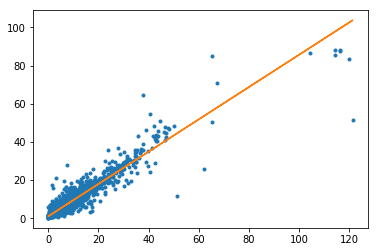

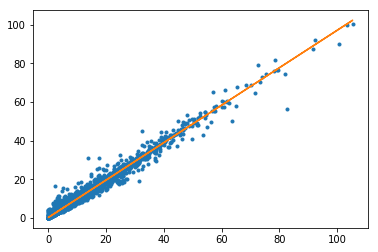

Score for Test set:  0.9014334910868383
Score for Train set:  0.9865365241485009


In [87]:
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 10, max_depth = 60)

X = Concat_w_dummies_noNaN_noSpace_1611dropped.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_1611dropped['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [95]:
X_test.iloc[924:925, :]

,BENEFIT,BKMOB,BKVOL,BRANLIB,CAPITAL,CAP_REV,CENTLIB,EBOOK,ELMATEXP,FCAP_REV,...,STABR_WY,C_LEGBAS-C_LEGBASE_CC,C_LEGBAS-C_LEGBASE_CI,C_LEGBAS-C_LEGBASE_CO,C_LEGBAS-C_LEGBASE_LD,C_LEGBAS-C_LEGBASE_MJ,C_LEGBAS-C_LEGBASE_NL,C_LEGBAS-C_LEGBASE_NP,C_LEGBAS-C_LEGBASE_OT,C_LEGBAS-C_LEGBASE_SD
28905,320228,0.0,77237.0,0.0,0.0,0.0,1.0,15564.0,7675.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [122]:
predictions = rfmodel.predict(X_test.iloc[924:925, :])
print(predictions)


new_test = X_test.iloc[924:925, :]

[10.50062074]


In [125]:
new_test[['Usage_PrevYear']] = new_test[['Usage_PrevYear']]*4

//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [126]:
predictions = rfmodel.predict(new_test)
print(predictions)

[43.73484849]


In [ ]:
### Conclusion: Of course, this works well. Usage last year predicts usage this year. 
#That's trivial. Really, I want to know what features contribute to differences in usage each year?

## Go back to running RF without previous year's usage info. (As done in previous notebook)

In [127]:
#Now, try to remove anything 5SD's higher than mean.
Concat_w_dummies_noNaN_noSpace_ri = Concat_w_dummies_noNaN_noSpace.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace_ri = Location_Detail_DF_noNaN_noSpace.reset_index(drop = True)

mean_plus_5xSD = Concat_w_dummies_noNaN_noSpace_ri.Usage.mean() + 5*Concat_w_dummies_noNaN_noSpace_ri.Usage.std()
OutlierIdx = Concat_w_dummies_noNaN_noSpace_ri[Concat_w_dummies_noNaN_noSpace_ri.Usage > mean_plus_5xSD].index
print("Number of outliers:", Concat_w_dummies_noNaN_noSpace_ri.loc[OutlierIdx, ['Usage']].shape[0])
      
Concat_w_dummies_noNaN_noSpace_ri_DropOutliers=Concat_w_dummies_noNaN_noSpace_ri.drop(OutlierIdx)
Location_Detail_DF_noNaN_noSpace_ri_DropOutliers=Location_Detail_DF_noNaN_noSpace_ri.drop(OutlierIdx)

print(Concat_w_dummies_noNaN_noSpace_ri.shape, Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.shape)
print(Location_Detail_DF_noNaN_noSpace_ri.shape, Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.shape)

Number of outliers: 42
(36626, 161) (36584, 161)
(36626, 6) (36584, 6)


In [128]:
###GET random set of libraries to remove
Location_Detail_DF_noNaN_noSpace_ri_DropOutliers = Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.reset_index(drop=True)
Concat_w_dummies_noNaN_noSpace_ri_DropOutliers = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.reset_index(drop=True)

UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri_DropOutliers[Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

6290
7309


                         importance
REGBOR                 6.883803e-02
OBEREG_5.0             4.810001e-02
TOTATTEN               3.981669e-02
PITUSR                 3.515690e-02
TOTPRO                 3.365584e-02
STGVT                  3.155670e-02
REFERENC-REFERENCE     3.005515e-02
TOTCIR                 3.002192e-02
DUPLI-HRS_OPEN         2.995878e-02
BKVOL                  2.835514e-02
OTHINCM                2.175080e-02
KIDCIRCL               2.100399e-02
OTHMATEX               2.022017e-02
SUBSCRIP-SUBSCRIPT     2.019023e-02
BRANLIB                1.835280e-02
OTHPAID                1.824056e-02
GPTERMS                1.823471e-02
KIDATTEN-KIDATTEND     1.780424e-02
VIDEO_PH               1.763630e-02
STABR_TX               1.759491e-02
LOANTO                 1.714051e-02
LOANFM                 1.709691e-02
LOCGVT                 1.562687e-02
LIBRARIAN-LIBRARIA     1.492768e-02
OTHOPEXP               1.452593e-02
BENEFIT                1.374177e-02
TOTPEMP-TOTSTAFF       1.353

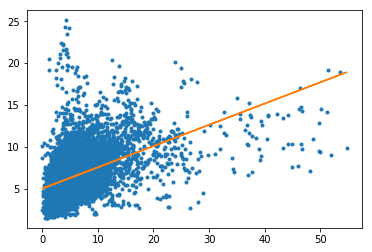

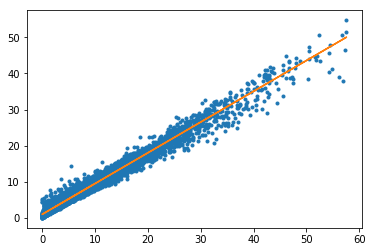

Score for Test set:  0.2104734498745363
Score for Train set:  0.9606797993108995


In [132]:
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too). 'Usage_PrevYear' removed as well. 
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA', 'Usage_PrevYear'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

## Use original dataset as above (Do NOT include 'Usage_PrevYear'), but run two different RFs for high and low usage.

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1aa91a5080>]]


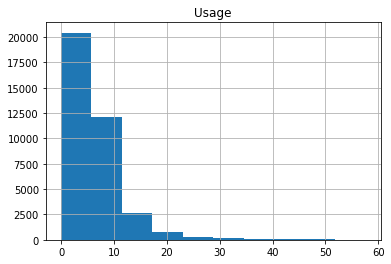

In [133]:
print(Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.hist(column='Usage', bins = 10))

In [152]:
#Call anything above 10 high usage, anything below 10 low usage.

print(Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.shape)
print(Concat_w_dummies_noNaN_noSpace_1611dropped.shape)
print(Concat_w_dummies_noNaN_noSpace.shape)
print(Location_Detail_DF_noNaN_noSpace_1611dropped.shape)

#Just use df where I drop Usage of 1611

Concat_w_dummies_noNaN_noSpace_1611dropped = Concat_w_dummies_noNaN_noSpace_1611dropped.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace_1611dropped = Location_Detail_DF_noNaN_noSpace_1611dropped.reset_index(drop = True)

#Separate DFs into low, high usage
IdxLowUsage = Concat_w_dummies_noNaN_noSpace_1611dropped[Concat_w_dummies_noNaN_noSpace_1611dropped.Usage <= 10].index
IdxHighUsage = Concat_w_dummies_noNaN_noSpace_1611dropped[Concat_w_dummies_noNaN_noSpace_1611dropped.Usage > 10].index

LowUsageDF = Concat_w_dummies_noNaN_noSpace_1611dropped.drop(IdxHighUsage)
HighUsageDF = Concat_w_dummies_noNaN_noSpace_1611dropped.drop(IdxLowUsage)

LowUsageLoc = Location_Detail_DF_noNaN_noSpace_1611dropped.drop(IdxHighUsage)
HighUsageLoc = Location_Detail_DF_noNaN_noSpace_1611dropped.drop(IdxLowUsage)

print(Concat_w_dummies_noNaN_noSpace_1611dropped.shape)
print(LowUsageDF.shape)
print(HighUsageDF.shape)

LowUsageDF = LowUsageDF.reset_index(drop = True)
HighUsageDF = HighUsageDF.reset_index(drop = True)

LowUsageLoc = LowUsageLoc.reset_index(drop = True)
HighUsageLoc = HighUsageLoc.reset_index(drop = True)


(36584, 161)
(36625, 161)
(36626, 161)
(36625, 6)
(36625, 161)
(31047, 161)
(5578, 161)


In [153]:
#Remove 20% of libraries for LOW usage model
UniqueFSCS = set(LowUsageLoc.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = LowUsageLoc[LowUsageLoc.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))

LowUsage_flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(LowUsage_flattened_Indexlist))


#Remove 20% of libraries for HIGH usage model
UniqueFSCS = set(HighUsageLoc.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = HighUsageLoc[HighUsageLoc.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))

HighUsage_flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(HighUsage_flattened_Indexlist))

5714
6158
1313
1043


                         importance
OBEREG_5.0             8.599136e-02
REGBOR                 4.372101e-02
TOTCIR                 4.328648e-02
OBEREG_6.0             3.799599e-02
STGVT                  3.456263e-02
DUPLI-HRS_OPEN         3.168724e-02
OTHMATEX               2.979137e-02
SUBSCRIP-SUBSCRIPT     2.883665e-02
BKVOL                  2.681897e-02
TOTATTEN               2.527935e-02
REFERENC-REFERENCE     2.523327e-02
PITUSR                 2.494363e-02
KIDCIRCL               2.339070e-02
LOANFM                 2.200035e-02
VIDEO_PH               2.126025e-02
OTHINCM                2.065303e-02
LOANTO                 1.931040e-02
OTHPAID                1.795930e-02
AUDIO                  1.755274e-02
GEOCODE_CI1            1.707703e-02
BENEFIT                1.626529e-02
LIBRARIAN-LIBRARIA     1.621782e-02
TOTPRO                 1.602215e-02
LOCGVT                 1.569529e-02
GPTERMS                1.566095e-02
YAATTEN                1.542182e-02
KIDPRO                 1.538

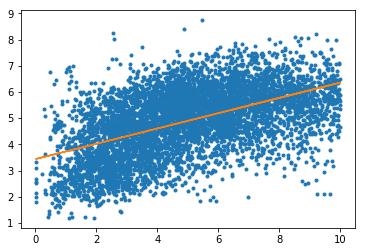

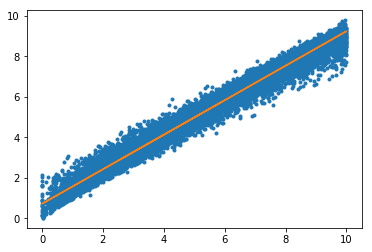

Score for Test set:  0.280878570498831
Score for Train set:  0.9593894709958029


In [154]:
#RF with LowUsageDF
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = LowUsageDF.drop(columns = ['Usage', 'POPU-POPU_LSA', 'Usage_PrevYear'])
y = LowUsageDF['Usage']

X_train = X.drop(X.index[LowUsage_flattened_Indexlist])
y_train = y.drop(y.index[LowUsage_flattened_Indexlist])
X_test = X.loc[LowUsage_flattened_Indexlist]
y_test = y.loc[LowUsage_flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

                      importance
STGVT               7.830433e-02
REGBOR              5.574302e-02
PITUSR              4.869970e-02
BKVOL               4.512536e-02
KIDATTEN-KIDATTEND  3.850846e-02
DUPLI-HRS_OPEN      3.182030e-02
OTHOPEXP            3.106946e-02
KIDCIRCL            3.042665e-02
SUBSCRIP-SUBSCRIPT  3.002528e-02
TOTATTEN            2.838585e-02
REFERENC-REFERENCE  2.759078e-02
YAPRO               2.506645e-02
OTHINCM             2.380293e-02
TOTCIR              2.371205e-02
OTHPAID             2.282917e-02
VIDEO               2.212581e-02
TOTPRO              2.171139e-02
LOCGVT              2.156246e-02
GPTERMS             2.134965e-02
LOANFM              1.800168e-02
STABR_MA            1.644807e-02
LOANTO              1.520992e-02
LIBRARIAN-LIBRARIA  1.514226e-02
TOTOPEXP-TOTOPEXP1  1.316850e-02
TOTPEMP-TOTSTAFF    1.314483e-02
KIDPRO              1.276239e-02
MASTER              1.235916e-02
SALARIES            1.234361e-02
TOTEXPCO-TOTEXPCOL  1.184815e-02
TOTINCM   

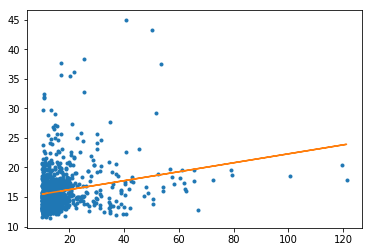

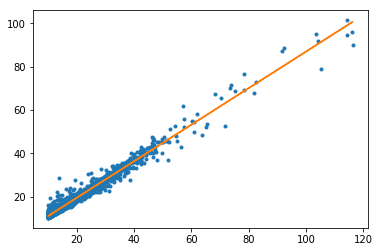

Score for Test set:  0.035761701640043664
Score for Train set:  0.9569420753517032


In [155]:
#RF with HighUsageDF
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = HighUsageDF.drop(columns = ['Usage', 'POPU-POPU_LSA', 'Usage_PrevYear'])
y = HighUsageDF['Usage']

X_train = X.drop(X.index[HighUsage_flattened_Indexlist])
y_train = y.drop(y.index[HighUsage_flattened_Indexlist])
X_test = X.loc[HighUsage_flattened_Indexlist]
y_test = y.loc[HighUsage_flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

## Go back to running RF without previous year's usage info. (As done in previous notebook)

In [160]:
##Show this to Jolene.

In [157]:
#Now, try to remove anything 5SD's higher than mean.
Concat_w_dummies_noNaN_noSpace_ri = Concat_w_dummies_noNaN_noSpace.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace_ri = Location_Detail_DF_noNaN_noSpace.reset_index(drop = True)

mean_plus_5xSD = Concat_w_dummies_noNaN_noSpace_ri.Usage.mean() + 5*Concat_w_dummies_noNaN_noSpace_ri.Usage.std()
OutlierIdx = Concat_w_dummies_noNaN_noSpace_ri[Concat_w_dummies_noNaN_noSpace_ri.Usage > mean_plus_5xSD].index
print("Number of outliers:", Concat_w_dummies_noNaN_noSpace_ri.loc[OutlierIdx, ['Usage']].shape[0])
      
Concat_w_dummies_noNaN_noSpace_ri_DropOutliers=Concat_w_dummies_noNaN_noSpace_ri.drop(OutlierIdx)
Location_Detail_DF_noNaN_noSpace_ri_DropOutliers=Location_Detail_DF_noNaN_noSpace_ri.drop(OutlierIdx)

print(Concat_w_dummies_noNaN_noSpace_ri.shape, Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.shape)
print(Location_Detail_DF_noNaN_noSpace_ri.shape, Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.shape)

Number of outliers: 42
(36626, 161) (36584, 161)
(36626, 6) (36584, 6)


In [158]:
###GET random set of libraries to remove
Location_Detail_DF_noNaN_noSpace_ri_DropOutliers = Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.reset_index(drop=True)
Concat_w_dummies_noNaN_noSpace_ri_DropOutliers = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.reset_index(drop=True)

UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri_DropOutliers[Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

6290
7381


                         importance
REGBOR                 6.325809e-02
OBEREG_5.0             4.895238e-02
PITUSR                 3.864159e-02
TOTATTEN               3.491890e-02
STGVT                  3.284263e-02
TOTPRO                 3.042043e-02
SUBSCRIP-SUBSCRIPT     2.924699e-02
TOTCIR                 2.847209e-02
REFERENC-REFERENCE     2.795279e-02
DUPLI-HRS_OPEN         2.780199e-02
BKVOL                  2.718507e-02
OTHINCM                2.638696e-02
OTHMATEX               2.161602e-02
VIDEO_PH               2.078448e-02
KIDCIRCL               2.059233e-02
LOANFM                 2.012891e-02
LOCGVT                 2.009776e-02
OTHPAID                1.901938e-02
BRANLIB                1.858534e-02
GPTERMS                1.697136e-02
LOANTO                 1.657373e-02
OTHOPEXP               1.556416e-02
BENEFIT                1.468058e-02
STABR_TX               1.457333e-02
LIBRARIAN-LIBRARIA     1.395185e-02
KIDATTEN-KIDATTEND     1.388699e-02
PRMATEXP               1.384

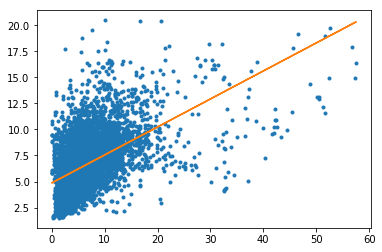

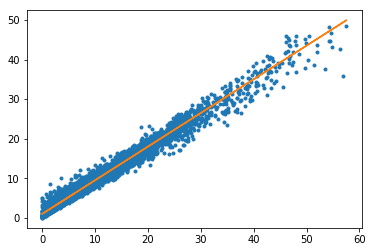

Score for Test set:  0.27449703599476927
Score for Train set:  0.9609486975230076


In [159]:
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too). 'Usage_PrevYear' removed as well. 
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA', 'Usage_PrevYear'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

## Try to predict 0 vs. 1 instead??? Using RF or LR

### Divide some values by population to serve??

In [161]:
cols = list(Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.columns)



['BENEFIT',
 'BKMOB',
 'BKVOL',
 'BRANLIB',
 'CAPITAL',
 'CAP_REV',
 'CENTLIB',
 'EBOOK',
 'ELMATEXP',
 'FCAP_REV',
 'GPTERMS',
 'DUPLI-HRS_OPEN',
 'KIDATTEN-KIDATTEND',
 'KIDCIRCL',
 'KIDPRO',
 'LIBRARIAN-LIBRARIA',
 'LOANFM',
 'LOANTO',
 'LOCGVT',
 'MASTER',
 'OCAP_REV',
 'OTHINCM',
 'OTHMATEX',
 'OTHOPEXP',
 'OTHPAID',
 'PITUSR',
 'POPU-POPU_LSA',
 'PRMATEXP',
 'REFERENC-REFERENCE',
 'REGBOR',
 'SALARIES',
 'SCAP_REV',
 'STAFFEXP-TOTEXP',
 'STGVT',
 'SUBSCRIP-SUBSCRIPT',
 'TOTATTEN',
 'TOTCIR',
 'TOTEXPCO-TOTEXPCOL',
 'TOTINCM',
 'TOTOPEXP-TOTOPEXP1',
 'TOTPRO',
 'TOTPEMP-TOTSTAFF',
 'VIDEO_DL',
 'VIDEO_PH',
 'YAATTEN',
 'YAPRO',
 'AUDIO',
 'VIDEO',
 'Usage',
 'Usage_PrevYear',
 'GEOCODE_CI1',
 'GEOCODE_CI2',
 'GEOCODE_CO1',
 'GEOCODE_CO2',
 'GEOCODE_MA1',
 'GEOCODE_MA2',
 'GEOCODE_MC1',
 'GEOCODE_MC2',
 'GEOCODE_OTH',
 'GEOCODE_SD1',
 'GEOCODE_SD2',
 'LOCALE_11.0',
 'LOCALE_12.0',
 'LOCALE_13.0',
 'LOCALE_21.0',
 'LOCALE_22.0',
 'LOCALE_23.0',
 'LOCALE_31.0',
 'LOCALE_32.0',
 'LOCA

In [168]:
test = copy.deepcopy(Concat_w_dummies_noNaN_noSpace_ri_DropOutliers)

In [173]:
Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.dtypes

BENEFIT                   object
BKMOB                    float64
BKVOL                    float64
BRANLIB                  float64
CAPITAL                  float64
CAP_REV                  float64
CENTLIB                  float64
EBOOK                    float64
ELMATEXP                 float64
FCAP_REV                 float64
GPTERMS                  float64
DUPLI-HRS_OPEN           float64
KIDATTEN-KIDATTEND       float64
KIDCIRCL                 float64
KIDPRO                   float64
LIBRARIAN-LIBRARIA       float64
LOANFM                   float64
LOANTO                   float64
LOCGVT                   float64
MASTER                   float64
OCAP_REV                 float64
OTHINCM                  float64
OTHMATEX                 float64
OTHOPEXP                  object
OTHPAID                  float64
PITUSR                   float64
POPU-POPU_LSA            float64
PRMATEXP                 float64
REFERENC-REFERENCE       float64
REGBOR                   float64
          

In [183]:
for col in test.columns[:10]:
    print(col)
    test[col] = test[col].astype(float)
    test[col] = test[col]/test[['POPU-POPU_LSA']]

BENEFIT


KeyboardInterrupt: 

## Everything below is old library - can delete incrementally.

## Random Forest Model #1 - code condensed from Library_Week2_Notebook4_Strategy#2

In [ ]:
#Take out 20% of libraries randomly for testing

import random
print(Concat_w_dummies_noNaN.shape)
print(Concat_w_dummies_noNaN_noSpace.shape)
print(Location_Detail_DF_noNaN.shape)
print(Location_Detail_DF_noNaN_noSpace.shape)

Concat_w_dummies_noNaN_noSpace_ri = Concat_w_dummies_noNaN_noSpace.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace_ri = Location_Detail_DF_noNaN_noSpace.reset_index(drop = True)

UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri[Location_Detail_DF_noNaN_noSpace_ri.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))

flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

In [ ]:
#RF with SPECIFIC libraries removed.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);

predictions = rfmodel.predict(X_test)

errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame(predictions, y_test)
df['errors'] = (list(errors))

In [ ]:
print(rfmodel.score(X_test, y_test))
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

In [ ]:
from numpy.polynomial.polynomial import polyfit

# Sample data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.xlim((0, 30))
plt.ylim((0, 40))
plt.show()


In [ ]:
#Can out-of-bag estimates substitute for a separate test set??
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score=True)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

rfmodel.fit(X, y);

oob_error = 1 - rfmodel.oob_score_

predictions = rfmodel.predict(X)
errors = abs(predictions - y)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y
df['Predictions'] = predictions
df['errors'] = (list(errors))

#Probably not...oob error is VERY large. So training and testing on same dataset is not valid. (Although if I train and test on same set, then rsults are VERY good and capital is best predictor. Does this tell me anything??)

In [ ]:
print(rfmodel.oob_score_)

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


In [ ]:
df

In [ ]:
from numpy.polynomial.polynomial import polyfit

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()

In [ ]:
#Go back to RF with SPECIFIC libraries removed.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);

predictions = rfmodel.predict(X_test)

errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y_test
df['Predictions'] = predictions
df['errors'] = (list(errors))

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

In [ ]:
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.ylim(0, 40)
plt.xlim(0, 40)
plt.show()

In [ ]:
df['Usage_bin'] = pd.qcut(df['Usage_val'], 4)
df['Predictions_bin'] = pd.qcut(df['Predictions'], 4)

df = df.reset_index(drop = True)
df['Usage_bin_val'] = ""
df['Predictions_bin_val'] = ""

Usage_bin_list = df['Usage_bin'].unique()
Predictions_bin_list = df['Predictions_bin'].unique()

for j in range(df.shape[0]):
    for i in range(4):
        if str(df.loc[j, 'Usage_bin']) == str(Usage_bin_list[i]):
            df.loc[j, 'Usage_bin_val'] = i+1 
        if str(df.loc[j, 'Predictions_bin']) == str(Predictions_bin_list[i]):
            df.loc[j, 'Predictions_bin_val'] = i+1 
                               

In [ ]:
sum_equal = 0

for i in range(df.shape[0]):
    if df.loc[i, 'Usage_bin_val'] == df.loc[i, 'Predictions_bin_val']:
        sum_equal = sum_equal+1
print(sum_equal, df.shape[0])

In [ ]:
df["Difference"] = abs(df['Usage_bin_val'] - df['Predictions_bin_val'])

In [ ]:
df.hist(column='Difference')

In [ ]:
df['error_pct'] = df['errors']/df['Usage_val']

sum_error = 0

for i in range(df.shape[0]):
    if df.loc[i, 'error_pct'] <= .3:
        sum_error = sum_error + 1
print(sum_error, df.shape[0])

In [ ]:
df

In [ ]:
print(feature_importances)

In [ ]:
df.hist(column='Usage_val', bins = len(df['Usage_val'].unique()))

In [ ]:
#RF with SPECIFIC libraries removed, but POPU-POPU_LSA kept in.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);

predictions = rfmodel.predict(X_test)

errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y_test
df['Predictions'] = predictions
df['errors'] = (list(errors))

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#If I put back population, it looks like prediction improves a lot. BUT that's super unfair and I won't actually get anything meaningful out of it. 

In [ ]:
#Next, try RF with train and test set (without removing specific libraries)

#RF with SPECIFIC libraries removed, but POPU-POPU_LSA kept in.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y_test
df['Predictions'] = predictions
df['errors'] = (list(errors))

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

In [ ]:
df

In [ ]:
df = df.reset_index(drop = True)
df['error_pct'] = df['errors']/df['Usage_val']

sum_error = 0

for i in range(df.shape[0]):
    if df.loc[i, 'error_pct'] <= .35:
        sum_error = sum_error + 1
#print(sum_error, df.shape[0])

In [ ]:
#Get rid of usage 0 to get mean error
df[df['Usage_val'] == 0].index

In [ ]:
df = df.drop(df[df['Usage_val'] == 0].index)

In [ ]:
df['error_pct'].mean()

In [ ]:
list(df['error_pct'])

In [ ]:
df['error_pct'].max()

In [ ]:
df[df['error_pct'] > 8000].index

In [ ]:
df.loc[3502, :]

## After 2:30 standup

### I should run the model the right way. Take 20% of libraries out first!

In [ ]:
###GET random set of libraries to remove
UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri[Location_Detail_DF_noNaN_noSpace_ri.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

In [ ]:
#RF with SPECIFIC libraries removed, but POPU-POPU_LSA kept in.
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [ ]:
print(rfmodel.score(X_test, y_test))
print(rfmodel.score(X_train, y_train))

In [ ]:
print(df_TEST['errors'].max())
print(df_TRAIN['errors'].max())
idx = df_TEST[df_TEST['errors'] > 1600].index
print(idx)
df_TEST.loc[33595, :]

In [ ]:
y_test.max()

### Take out usage outliers! (As shown above, there are definitely some!)

In [ ]:
print(Location_Detail_DF_noNaN_noSpace_ri.shape)
print(Concat_w_dummies_noNaN_noSpace_ri.shape)

In [ ]:
#Remove anything 5SD's higher than mean?
mean_plus_5xSD = Concat_w_dummies_noNaN_noSpace_ri.Usage.mean() + 5*Concat_w_dummies_noNaN_noSpace_ri.Usage.std()
OutlierIdx = Concat_w_dummies_noNaN_noSpace_ri[Concat_w_dummies_noNaN_noSpace_ri.Usage > mean_plus_5xSD].index
Concat_w_dummies_noNaN_noSpace_ri.loc[OutlierIdx, ['Usage']]



In [ ]:
#Actually, for starters let's simply remove row 33595, with usage >1600
Location_Detail_DF_noNaN_noSpace_ri_1611dropped = Location_Detail_DF_noNaN_noSpace_ri.drop([33595])
Concat_w_dummies_noNaN_noSpace_ri_1611dropped = Concat_w_dummies_noNaN_noSpace_ri.drop([33595])

Location_Detail_DF_noNaN_noSpace_ri_1611dropped = Location_Detail_DF_noNaN_noSpace_ri_1611dropped.reset_index(drop = True)
Concat_w_dummies_noNaN_noSpace_ri_1611dropped = Concat_w_dummies_noNaN_noSpace_ri_1611dropped.reset_index(drop = True)



In [ ]:
###GET random set of libraries to remove
UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri_1611dropped.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri_1611dropped[Location_Detail_DF_noNaN_noSpace_ri_1611dropped.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

In [ ]:
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too). [Single outlier dropped]
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri_1611dropped.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_1611dropped['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [ ]:
print(df_TEST['errors'].max())
print(df_TRAIN['errors'].max())

In [ ]:
#take out outliers!!
#plot correlation map
#email Jolene

In [ ]:
df_TEST.loc[df_TEST[df_TEST['errors'] > 90].index, :]

In [ ]:
FSCSKeys_Used_Above_Jan28_535pm = _20PctFSCSList

In [ ]:
#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [ ]:
FSCSKeys_Used_Above_Jan28_550pm = _20PctFSCSList

In [ ]:
df_TEST['error_pct'] = df_TEST['errors']/df_TEST['Usage_val']

sum_error = 0

df_TEST = df_TEST.reset_index(drop = True)

for i in range(df_TEST.shape[0]):
    if df_TEST.loc[i, 'error_pct'] <= .5:
        sum_error = sum_error + 1
print(sum_error, df.shape[0])

## Try to reduce overfitting in RFM

In [ ]:
### #1. Increase number of trees 10-fold
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 1000, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#Increasing estimators to 1000 did not do anything!
#This is good to know. Took a while to run, so reduce back to 100 trees.

In [ ]:
### #2. Reduce number of trees back to 100. Reduce max_features from auto (total features) to sqrt (sqrt(features))
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_features = "sqrt")

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#Doesn't really change much.

In [ ]:
### #3. Reduce number of trees back to 100. Change max_features back to auto (total features). Reduce max_depth to 10 (this is a bit arbitrary and pretty low; can consider increasing).
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 10)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#Train set is worse, but test set is no better.

In [ ]:
### #3. Reduce number of trees back to 100. Increase max_depth to 100.
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 100)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#Train set score jumps back up, test score still low

In [ ]:
### #4. Try max depth between 10 and 100
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]
    
var_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for number in var_depth:
    rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = number)
    rfmodel.fit(X_train, y_train)
    print("max_depth = ", number)
    print("Score for Test set: ", rfmodel.score(X_test, y_test))
    print("Score for Train set: ", rfmodel.score(X_train, y_train))  

In [ ]:
### #5. Try max depth 40, max_features to sqrt (sqrt(features))
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]
    

rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 40, max_features = "sqrt")
rfmodel.fit(X_train, y_train)
print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#n_estimators = 100
#max_features = 30-50% of the number of features (reducing may reduce overfitting; right now, it's # of features)






In [ ]:
### #6. Try max_features to sqrt (sqrt(features)), min_samples_leaf to 15
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]
    

rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_features = "sqrt", min_samples_leaf = 15)
rfmodel.fit(X_train, y_train)
print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [ ]:
m_s_l_list = [1, 2, 5, 10, 15]
for number in m_s_l_list:
    rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_features = "auto", min_samples_leaf = number)
    rfmodel.fit(X_train, y_train)
    print("min_sample_leaf: ", number)
    print("Score for Test set: ", rfmodel.score(X_test, y_test))
    print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [ ]:
##Back to original model. Is R2 score schewed by a few very bad error?
#Left max_depth at 60, because R2 is about the same as if max_depth not set. 
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [ ]:
#calculate R2 
numerator = sum((df_TEST['Usage_val']-df_TEST['Predictions'])**2)
denominator = sum((df_TEST['Usage_val']-df_TEST['Usage_val'].mean())**2)
1-numerator/denominator

In [ ]:
#TRY to classify instead (0, 1, 2, 3, 4)

In [ ]:
list(df_TEST['errors'])

In [ ]:
print(df_TEST.hist(column='errors'))
print(df_TRAIN.hist(column='errors'))
print(df_TEST.hist(column='Usage_val'))
print(df_TRAIN.hist(column='Usage_val'))

In [ ]:
print(df_TEST[df_TEST['errors'] > 20].head())
len(df_TEST[df_TEST['errors'] > 20])

In [ ]:
#calculate R2 for all where 'Usage_val' < 30.
idx_high = df_TEST[df_TEST['Usage_val'] > 30].index
df_TEST_lowuseonly = df_TEST.drop(idx_high)
numerator = sum((df_TEST_lowuseonly['Usage_val']-df_TEST_lowuseonly['Predictions'])**2)
denominator = sum((df_TEST_lowuseonly['Usage_val']-df_TEST_lowuseonly['Usage_val'].mean())**2)
1-numerator/denominator

In [ ]:
#Save libraries used
my_list = _20PctFSCSList
with open('your_file.txt', 'w') as f:
    for item in my_list:
        f.write("%s\n" % item)

In [ ]:
FSCSKeys_Used_Above_Jan29_10am = _20PctFSCSList